In [1]:
from tensorflow import keras
#keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
from tensorflow.keras.applications.densenet import DenseNet121
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

def Densenet121(show_layers,weights,input_shape):
        base_model = DenseNet121(include_top=False, weights=weights, input_shape=input_shape)
        x = GlobalAveragePooling2D()(base_model.output)
        pred = Dense(1, activation='sigmoid')(x)
    
        model = Model(inputs=base_model.input, outputs=pred)
        model.compile(optimizer=SGD(lr=1e-2, decay=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
        if show_layers:
            for i, layer in enumerate(model.layers):
                print(i, layer.name, layer.trainable)
        return model
    
model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

# Protocol4 densenet학습

## PRLAB DB

## 0.01

In [1]:
from tensorflow import keras
#keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
from tensorflow.keras.applications.densenet import DenseNet121
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

def Densenet121(show_layers,weights,input_shape):
        base_model = DenseNet121(include_top=False, weights=weights, input_shape=input_shape)
        x = GlobalAveragePooling2D()(base_model.output)
        pred = Dense(1, activation='sigmoid')(x)
    
        model = Model(inputs=base_model.input, outputs=pred)
        model.compile(optimizer=SGD(lr=1e-2, decay=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
        if show_layers:
            for i, layer in enumerate(model.layers):
                print(i, layer.name, layer.trainable)
        return model
    
model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

- 학습

In [2]:
#### import glob
import os
import numpy as np
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'E:\\Face_Database\\B-Database'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'protocol_4'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'protocol_4'
    
    saveDir =  '.\\result_cuda'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, validDB,'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)

    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_accuracy'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  protocol_4
============================================Densenet121=============================================
Found 41040 images belonging to 2 classes.
Found 30240 images belonging to 2 classes.
train shape : (41040,)
Epoch 1/100
 478/5130 [=>............................] - ETA: 44:46 - loss: 0.4314 - accuracy: 0.8036

MemoryError: Unable to allocate 4.59 MiB for an array with shape (8, 224, 224, 3) and data type float32

- Test

In [3]:
# 학습된 모델 테스트셋에서 성능 평가
# 얼굴 스푸핑 분야에서 평가 metric으로 HTER이랑 EER 두 개 주로 사용
# =========================================

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight


%matplotlib inline

def main():
    inputSize = 224
    batchSize = 8
    
    trainDB = 'protocol_4'
    testDB = 'protocol_4'
    
    dataDir = 'E:\\Face_Database\\B-Database'
    modelPath = 'F:\\prlab\\ysg\\densenet-spoofing\\Densenet_result\\0.001\\result_PR-FASD\\protocol_4-16-0.1216_0.01.hdf5'
    
    print('>> model loaded: {}'.format(os.path.basename(modelPath)))
    K.clear_session()
    model = load_model(modelPath)
        
    print(">>>> evaluating on '{}'".format(testDB))
    test_datagen = ImageDataGenerator()

    val_datagen = ImageDataGenerator()
    
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_generator = val_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'val']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)
    
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'test']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)

    ''' evaluating EER '''
    y_true = val_generator.classes
    y_score = model.predict_generator(val_generator, steps=len(val_generator)).ravel()

    
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
    val_eer = (fpr[np.nanargmin(np.absolute((fnr - fpr)))] + fnr[np.nanargmin(np.absolute((fnr - fpr)))]) / 2

    ''' evaluating HTER '''
    y_true = test_generator.classes
    y_score = model.predict_generator(test_generator, steps = len(test_generator)).ravel()

    # Calculate EER threshold
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]

    # HTER
    y_pred = y_score > eer_threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = test_generator.class_indices
    print('                  pred_fake({})   pred_real({})\nactural_fake({})    {:12d}   {:12d}\nactual_real({})    {:12d}   {:12d}\n'.format(labels['Fake'], labels['Real'], labels['Fake'], tn, fp, labels['Real'], fn, tp))
    hter = (fp/(tn+fp) + fn/(fn+tp)) * 0.5

    # ROC curve
    Accuracy = ((tn+tp) / (tn+fp+fn+tp)) * 100.0

    roc_auc = roc_auc_score(y_true, y_score)

    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, 'r--', label='ROC_curve (acc_1st = %0.2f%%)' % Accuracy)
    plt.plot([0, 1], [0, 1], color = 'orange', lw=lw, linestyle='--')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")

    plt.savefig('protocol_4_001.png')
    plt.figure()
    
    print('EER: {:.4f}\tHTER: {:.4f}'.format(val_eer, hter))

    print('>> finished')

        
if __name__ == '__main__':
    main()

>> model loaded: protocol_4-16-0.1216_0.01.hdf5


KeyboardInterrupt: 

## 0.001

In [1]:
from tensorflow import keras
#keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
from tensorflow.keras.applications.densenet import DenseNet121
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

def Densenet121(show_layers,weights,input_shape):
        base_model = DenseNet121(include_top=False, weights=weights, input_shape=input_shape)
        x = GlobalAveragePooling2D()(base_model.output)
        pred = Dense(1, activation='sigmoid')(x)
    
        model = Model(inputs=base_model.input, outputs=pred)
        model.compile(optimizer=SGD(lr=1e-3, decay=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
        if show_layers:
            for i, layer in enumerate(model.layers):
                print(i, layer.name, layer.trainable)
        return model
    
model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

- 학습

>>  protocol_4
============================================Densenet121=============================================
Found 41040 images belonging to 2 classes.
Found 30240 images belonging to 2 classes.
train shape : (41040,)
Epoch 1/100
5129/5130 [============================>.] - ETA: 0s - loss: 0.2873 - accuracy: 0.8822
Epoch 00001: val_loss improved from inf to 0.54901, saving model to .\result_cuda\protocol_4-01-0.5490.hdf5
5130/5130 [==============================] - 3424s 667ms/step - loss: 0.2872 - accuracy: 0.8822 - val_loss: 0.5490 - val_accuracy: 0.7596
Epoch 2/100
5129/5130 [============================>.] - ETA: 0s - loss: 0.1386 - accuracy: 0.9477
Epoch 00002: val_loss did not improve from 0.54901
5130/5130 [==============================] - 3391s 661ms/step - loss: 0.1386 - accuracy: 0.9477 - val_loss: 10.2199 - val_accuracy: 0.3333
Epoch 3/100
5129/5130 [============================>.] - ETA: 0s - loss: 0.0970 - accuracy: 0.9649
Epoch 00003: val_loss improved from 0.5490

Epoch 27/100
5129/5130 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9992
Epoch 00027: val_loss did not improve from 0.07447
5130/5130 [==============================] - 3475s 677ms/step - loss: 0.0046 - accuracy: 0.9992 - val_loss: 0.0784 - val_accuracy: 0.9710
Epoch 28/100
5129/5130 [============================>.] - ETA: 0s - loss: 0.0069 - accuracy: 0.9989
Epoch 00028: val_loss did not improve from 0.07447
5130/5130 [==============================] - 3432s 669ms/step - loss: 0.0069 - accuracy: 0.9989 - val_loss: 0.0823 - val_accuracy: 0.9709
Epoch 29/100
5129/5130 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.9983
Epoch 00029: val_loss did not improve from 0.07447
5130/5130 [==============================] - 3445s 672ms/step - loss: 0.0078 - accuracy: 0.9983 - val_loss: 0.1092 - val_accuracy: 0.9610
Epoch 30/100
5129/5130 [============================>.] - ETA: 0s - loss: 0.0113 - accuracy: 0.9976
Epoch 00030: val_loss did not imp

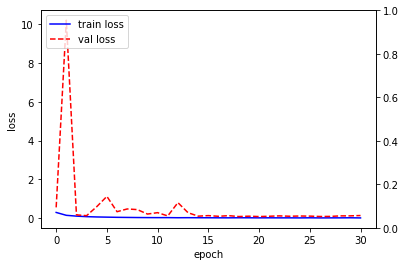

acc: 0.9727	loss: 0.0745
========================================protocol_4 finished=========================================


In [3]:
#### import glob
import os
import numpy as np
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'E:\\Face_Database\\B-Database'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'protocol_4'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'protocol_4'
    
    saveDir =  '.\\result_cuda'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, validDB,'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)

    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_accuracy'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

- test

>> model loaded: protocol_4-21-0.0745_0.001.hdf5
>>>> evaluating on 'protocol_4'
Found 30240 images belonging to 2 classes.
Found 56160 images belonging to 2 classes.
                  pred_fake(0)   pred_real(1)
actural_fake(0)           36565            875
actual_real(1)             438          18282

EER: 0.0285	HTER: 0.0234
>> finished


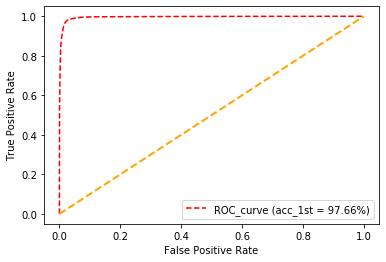

<Figure size 432x288 with 0 Axes>

In [5]:
# 학습된 모델 테스트셋에서 성능 평가
# 얼굴 스푸핑 분야에서 평가 metric으로 HTER이랑 EER 두 개 주로 사용
# =========================================

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight


%matplotlib inline

def main():
    inputSize = 224
    batchSize = 8
    
    trainDB = 'protocol_4'
    testDB = 'protocol_4'
    
    dataDir = 'E:\\Face_Database\\B-Database'
    modelPath = 'C:\\Users\\ysk00\\OneDrive\\바탕 화면\\prlab\\ysg\\densenet-spoofing\\result_cuda\\protocol_4-21-0.0745_0.001.hdf5'
    
    print('>> model loaded: {}'.format(os.path.basename(modelPath)))
    K.clear_session()
    model = load_model(modelPath)
        
    print(">>>> evaluating on '{}'".format(testDB))
    test_datagen = ImageDataGenerator()

    val_datagen = ImageDataGenerator()
    
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_generator = val_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'val']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)
    
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'test']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)

    ''' evaluating EER '''
    y_true = val_generator.classes
    y_score = model.predict_generator(val_generator, steps=len(val_generator)).ravel()

    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
    val_eer = (fpr[np.nanargmin(np.absolute((fnr - fpr)))] + fnr[np.nanargmin(np.absolute((fnr - fpr)))]) / 2

    ''' evaluating HTER '''
    y_true = test_generator.classes
    y_score = model.predict_generator(test_generator, steps = len(test_generator)).ravel()

    # Calculate EER threshold
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]

    # HTER
    y_pred = y_score > eer_threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = test_generator.class_indices
    print('                  pred_fake({})   pred_real({})\nactural_fake({})    {:12d}   {:12d}\nactual_real({})    {:12d}   {:12d}\n'.format(labels['Fake'], labels['Real'], labels['Fake'], tn, fp, labels['Real'], fn, tp))
    hter = (fp/(tn+fp) + fn/(fn+tp)) * 0.5

    # ROC curve
    Accuracy = ((tn+tp) / (tn+fp+fn+tp)) * 100.0

    roc_auc = roc_auc_score(y_true, y_score)

    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, 'r--', label='ROC_curve (acc_1st = %0.2f%%)' % Accuracy)
    plt.plot([0, 1], [0, 1], color = 'orange', lw=lw, linestyle='--')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")

    plt.savefig('protocol_4_001.png')
    plt.figure()
    
    print('EER: {:.4f}\tHTER: {:.4f}'.format(val_eer, hter))

    print('>> finished')

        
if __name__ == '__main__':
    main()

## 0.005


In [1]:
from tensorflow import keras
#keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
from tensorflow.keras.applications.densenet import DenseNet121
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

def Densenet121(show_layers,weights,input_shape):
        base_model = DenseNet121(include_top=False, weights=weights, input_shape=input_shape)
        x = GlobalAveragePooling2D()(base_model.output)
        pred = Dense(1, activation='sigmoid')(x)
    
        model = Model(inputs=base_model.input, outputs=pred)
        model.compile(optimizer=SGD(lr=5e-3, decay=5e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
        if show_layers:
            for i, layer in enumerate(model.layers):
                print(i, layer.name, layer.trainable)
        return model
    
model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

- 학습

>>  protocol_4
============================================Densenet121=============================================
Found 41040 images belonging to 2 classes.
Found 30240 images belonging to 2 classes.
train shape : (41040,)
Epoch 1/100
5129/5130 [============================>.] - ETA: 0s - loss: 0.2183 - accuracy: 0.9115
Epoch 00001: val_loss improved from inf to 0.26982, saving model to .\result_cuda\protocol_4-01-0.2698.hdf5
5130/5130 [==============================] - 3743s 730ms/step - loss: 0.2182 - accuracy: 0.9115 - val_loss: 0.2698 - val_accuracy: 0.9080
Epoch 2/100
5129/5130 [============================>.] - ETA: 0s - loss: 0.0756 - accuracy: 0.9735
Epoch 00002: val_loss improved from 0.26982 to 0.15320, saving model to .\result_cuda\protocol_4-02-0.1532.hdf5
5130/5130 [==============================] - 3620s 706ms/step - loss: 0.0756 - accuracy: 0.9735 - val_loss: 0.1532 - val_accuracy: 0.9500
Epoch 3/100
5129/5130 [============================>.] - ETA: 0s - loss: 0.0414 -

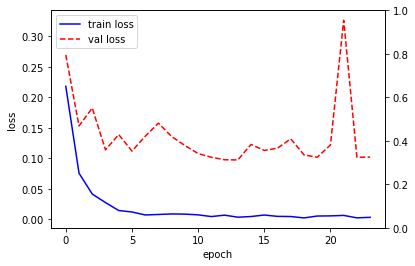

acc: 0.9647	loss: 0.0974
========================================protocol_4 finished=========================================


In [7]:
#### import glob
import os
import numpy as np
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'E:\\Face_Database\\B-Database'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'protocol_4'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'protocol_4'
    
    saveDir =  '.\\result_cuda'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, validDB,'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)

    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_accuracy'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

- Test

>> model loaded: protocol_4-21-0.0745_0.001.hdf5
>>>> evaluating on 'protocol_4'
Found 30240 images belonging to 2 classes.
Found 56160 images belonging to 2 classes.
                  pred_fake(0)   pred_real(1)
actural_fake(0)           36565            875
actual_real(1)             438          18282

EER: 0.0285	HTER: 0.0234
>> finished


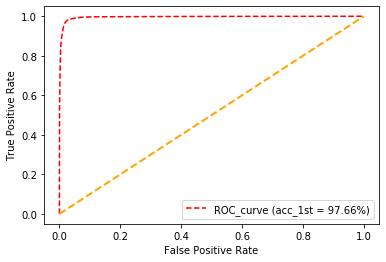

<Figure size 432x288 with 0 Axes>

In [2]:
# 학습된 모델 테스트셋에서 성능 평가
# 얼굴 스푸핑 분야에서 평가 metric으로 HTER이랑 EER 두 개 주로 사용
# =========================================

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight


%matplotlib inline

def main():
    inputSize = 224
    batchSize = 8
    
    trainDB = 'protocol_4'
    testDB = 'protocol_4'
    
    dataDir = 'E:\\Face_Database\\B-Database'
    modelPath = 'C:\\Users\\ysk00\\OneDrive\\바탕 화면\\prlab\\ysg\\densenet-spoofing\\result_cuda\\protocol_4-21-0.0745_0.001.hdf5'
    
    print('>> model loaded: {}'.format(os.path.basename(modelPath)))
    K.clear_session()
    model = load_model(modelPath)
        
    print(">>>> evaluating on '{}'".format(testDB))
    test_datagen = ImageDataGenerator()

    val_datagen = ImageDataGenerator()
    
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_generator = val_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'val']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)
    
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'test']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)

    ''' evaluating EER '''
    y_true = val_generator.classes
    y_score = model.predict_generator(val_generator, steps=len(val_generator)).ravel()

    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
    val_eer = (fpr[np.nanargmin(np.absolute((fnr - fpr)))] + fnr[np.nanargmin(np.absolute((fnr - fpr)))]) / 2

    ''' evaluating HTER '''
    y_true = test_generator.classes
    y_score = model.predict_generator(test_generator, steps = len(test_generator)).ravel()

    # Calculate EER threshold
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]

    # HTER
    y_pred = y_score > eer_threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = test_generator.class_indices
    print('                  pred_fake({})   pred_real({})\nactural_fake({})    {:12d}   {:12d}\nactual_real({})    {:12d}   {:12d}\n'.format(labels['Fake'], labels['Real'], labels['Fake'], tn, fp, labels['Real'], fn, tp))
    hter = (fp/(tn+fp) + fn/(fn+tp)) * 0.5

    # ROC curve
    Accuracy = ((tn+tp) / (tn+fp+fn+tp)) * 100.0

    roc_auc = roc_auc_score(y_true, y_score)

    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, 'r--', label='ROC_curve (acc_1st = %0.2f%%)' % Accuracy)
    plt.plot([0, 1], [0, 1], color = 'orange', lw=lw, linestyle='--')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")

    plt.savefig('protocol_4_001.png')
    plt.figure()
    
    print('EER: {:.4f}\tHTER: {:.4f}'.format(val_eer, hter))

    print('>> finished')

        
if __name__ == '__main__':
    main()

## 공개DB

## denset model

In [1]:
from tensorflow import keras
#keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
from tensorflow.keras.applications.densenet import DenseNet121
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

def Densenet121(show_layers,weights,input_shape):
        base_model = DenseNet121(include_top=False, weights=weights, input_shape=input_shape)
        x = GlobalAveragePooling2D()(base_model.output)
        pred = Dense(1, activation='sigmoid')(x)
    
        model = Model(inputs=base_model.input, outputs=pred)
        model.compile(optimizer=SGD(lr=1e-3, decay=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
        if show_layers:
            for i, layer in enumerate(model.layers):
                print(i, layer.name, layer.trainable)
        return model
    
model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## casia
- 학습

>>  1
============================================Densenet121=============================================
Found 21322 images belonging to 2 classes.
Found 6579 images belonging to 2 classes.
train shape : (21322,)
Epoch 1/100
2665/2666 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.9166
Epoch 00001: val_loss improved from inf to 0.05415, saving model to .\result_CASIA\1-01-0.2216.hdf5
2666/2666 [==============================] - 1625s 610ms/step - loss: 0.2215 - accuracy: 0.9166 - val_loss: 0.0542 - val_accuracy: 0.9995
Epoch 2/100
2665/2666 [============================>.] - ETA: 0s - loss: 0.0847 - accuracy: 0.9769
Epoch 00002: val_loss improved from 0.05415 to 0.01869, saving model to .\result_CASIA\1-02-0.0840.hdf5
2666/2666 [==============================] - 1608s 603ms/step - loss: 0.0848 - accuracy: 0.9769 - val_loss: 0.0187 - val_accuracy: 1.0000
Epoch 3/100
2665/2666 [============================>.] - ETA: 0s - loss: 0.0512 - accuracy: 0.9863
Epoch 00

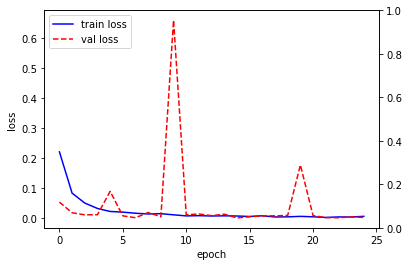

acc: 1.0000	loss: 0.0015
=============================================1 finished=============================================


In [7]:
#### import glob
import os
import numpy as np
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'E:\\Face_Database\\public-Database\\1_crop_result\\CASIA-FASD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '1'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '1' 
    
    saveDir = '.\\result_CASIA'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)

    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{loss:.4f}.hdf5')
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, validDB,'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)

    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_accuracy'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  2
============================================Densenet121=============================================
Found 20692 images belonging to 2 classes.
Found 7208 images belonging to 2 classes.
train shape : (20692,)
Epoch 1/100
2586/2587 [============================>.] - ETA: 0s - loss: 0.1883 - accuracy: 0.9323
Epoch 00001: val_loss improved from inf to 0.56943, saving model to .\result_CASIA\2-01-0.1882.hdf5
2587/2587 [==============================] - 1655s 640ms/step - loss: 0.1882 - accuracy: 0.9323 - val_loss: 0.5694 - val_accuracy: 0.7904
Epoch 2/100
2586/2587 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9796
Epoch 00002: val_loss improved from 0.56943 to 0.37349, saving model to .\result_CASIA\2-02-0.0688.hdf5
2587/2587 [==============================] - 1636s 632ms/step - loss: 0.0688 - accuracy: 0.9797 - val_loss: 0.3735 - val_accuracy: 0.8764
Epoch 3/100
2586/2587 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9883
Epoch 00

Epoch 27/100
2586/2587 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9994
Epoch 00027: val_loss did not improve from 0.01583
2587/2587 [==============================] - 1669s 645ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0365 - val_accuracy: 0.9815
Epoch 28/100
2586/2587 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.9994
Epoch 00028: val_loss did not improve from 0.01583
2587/2587 [==============================] - 1663s 643ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 0.0391 - val_accuracy: 0.9815
Epoch 29/100
2586/2587 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9998
Epoch 00029: val_loss did not improve from 0.01583
2587/2587 [==============================] - 1666s 644ms/step - loss: 0.0028 - accuracy: 0.9998 - val_loss: 0.0483 - val_accuracy: 0.9817
Epoch 30/100
2586/2587 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.9995
Epoch 00030: val_loss did not imp

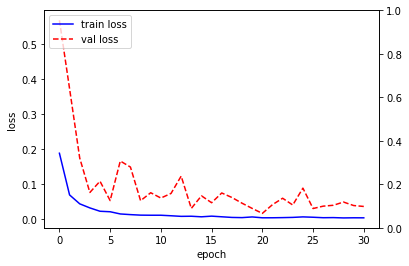

acc: 0.9992	loss: 0.0158
=============================================2 finished=============================================


In [8]:
#### import glob
import os
import numpy as np
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'E:\\Face_Database\\public-Database\\1_crop_result\\CASIA-FASD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '2'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '2' 
    
    saveDir = '.\\result_CASIA'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)

    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{loss:.4f}.hdf5')
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, validDB,'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)

    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_accuracy'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  3
============================================Densenet121=============================================
Found 20952 images belonging to 2 classes.
Found 6950 images belonging to 2 classes.
train shape : (20952,)
Epoch 1/100
2618/2619 [============================>.] - ETA: 0s - loss: 0.2147 - accuracy: 0.9214
Epoch 00001: val_loss improved from inf to 0.12198, saving model to .\result_CASIA\3-01-0.2146.hdf5
2619/2619 [==============================] - 1715s 655ms/step - loss: 0.2146 - accuracy: 0.9214 - val_loss: 0.1220 - val_accuracy: 0.9400
Epoch 2/100
2618/2619 [============================>.] - ETA: 0s - loss: 0.0744 - accuracy: 0.9792
Epoch 00002: val_loss improved from 0.12198 to 0.06054, saving model to .\result_CASIA\3-02-0.0744.hdf5
2619/2619 [==============================] - 1702s 650ms/step - loss: 0.0744 - accuracy: 0.9792 - val_loss: 0.0605 - val_accuracy: 0.9919
Epoch 3/100
2618/2619 [============================>.] - ETA: 0s - loss: 0.0449 - accuracy: 0.9879
Epoch 00

Epoch 28/100
2618/2619 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9991
Epoch 00028: val_loss did not improve from 0.00566
2619/2619 [==============================] - 1686s 644ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0224 - val_accuracy: 0.9957
Epoch 29/100
2618/2619 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9991
Epoch 00029: val_loss did not improve from 0.00566
2619/2619 [==============================] - 1703s 650ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 0.0204 - val_accuracy: 0.9974
Epoch 30/100
2618/2619 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 00030: val_loss did not improve from 0.00566
2619/2619 [==============================] - 1704s 651ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9981


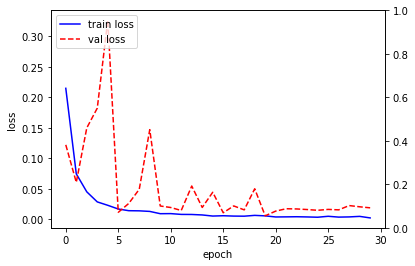

acc: 1.0000	loss: 0.0057
=============================================3 finished=============================================


In [10]:
#### import glob
import os
import numpy as np
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'E:\\Face_Database\\public-Database\\1_crop_result\\CASIA-FASD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '3'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '3' 
    
    saveDir = '.\\result_CASIA'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)

    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{loss:.4f}.hdf5')
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, validDB,'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)

    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_accuracy'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  4
============================================Densenet121=============================================
Found 20745 images belonging to 2 classes.
Found 7163 images belonging to 2 classes.
train shape : (20745,)
Epoch 1/100
2593/2594 [============================>.] - ETA: 0s - loss: 0.1795 - accuracy: 0.9370
Epoch 00001: val_loss improved from inf to 0.75001, saving model to .\result_CASIA\4-01-0.1795.hdf5
2594/2594 [==============================] - 1688s 651ms/step - loss: 0.1794 - accuracy: 0.9370 - val_loss: 0.7500 - val_accuracy: 0.8610
Epoch 2/100
2593/2594 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9879
Epoch 00002: val_loss did not improve from 0.75001
2594/2594 [==============================] - 1665s 642ms/step - loss: 0.0541 - accuracy: 0.9879 - val_loss: 3.1514 - val_accuracy: 0.4480
Epoch 3/100
2593/2594 [============================>.] - ETA: 0s - loss: 0.0318 - accuracy: 0.9932
Epoch 00003: val_loss improved from 0.75001 to 0.65423, savin

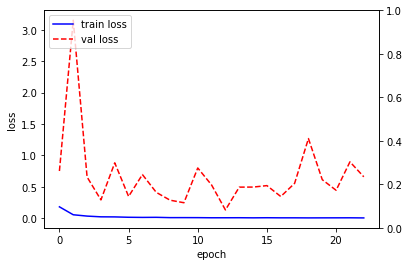

acc: 0.9386	loss: 0.1300
=============================================4 finished=============================================


In [11]:
#### import glob
import os
import numpy as np
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'E:\\Face_Database\\public-Database\\1_crop_result\\CASIA-FASD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '4'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '4' 
    
    saveDir = '.\\result_CASIA'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)

    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{loss:.4f}.hdf5')
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, validDB,'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)

    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_accuracy'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  Result
============================================Densenet121=============================================
Found 27901 images belonging to 2 classes.
train shape : (27901,)
Epoch 1/17
3487/3488 [============================>.] - ETA: 0s - loss: 0.1839 - accuracy: 0.9338
Epoch 00001: loss improved from inf to 0.18385, saving model to .\result_CASIA\Result-01-0.1839.hdf5
3488/3488 [==============================] - 2010s 576ms/step - loss: 0.1839 - accuracy: 0.9338
Epoch 2/17
3487/3488 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.9829
Epoch 00002: loss improved from 0.18385 to 0.05958, saving model to .\result_CASIA\Result-02-0.0596.hdf5
3488/3488 [==============================] - 1980s 568ms/step - loss: 0.0596 - accuracy: 0.9829
Epoch 3/17
3487/3488 [============================>.] - ETA: 0s - loss: 0.0355 - accuracy: 0.9911
Epoch 00003: loss improved from 0.05958 to 0.03548, saving model to .\result_CASIA\Result-03-0.0355.hdf5
3488/3488 [==============

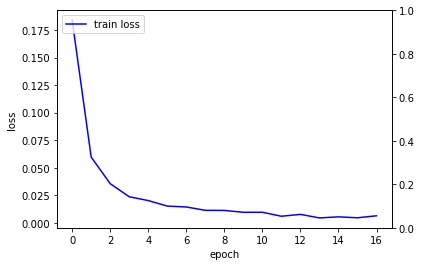

acc: 0.9970	loss: 0.0143
==========================================Result finished===========================================


In [2]:
#### import glob
import os
import numpy as np
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 17
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'E:\\Face_Database\\public-Database\\1_crop_result\\CASIA-FASD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'Result'  # D:\Face_Database\B-Database\protocol_4\train
 
    
    saveDir = '.\\result_CASIA'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)

    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{loss:.4f}.hdf5')
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

  
    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               verbose=1,
                               callbacks=[cb_checkpoint]
                               )

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
 #   loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['accuracy'][-11], hist.history['loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

- test

>> model loaded: Result-14-0.0044.hdf5
>>>> evaluating on 'CASIA-FASD'
Found 40389 images belonging to 2 classes.
                  pred_fake(0)   pred_real(1)
actural_fake(0)           29713            714
actual_real(1)             234           9728

EER: 0.0235	HTER: 0.0235
>> finished


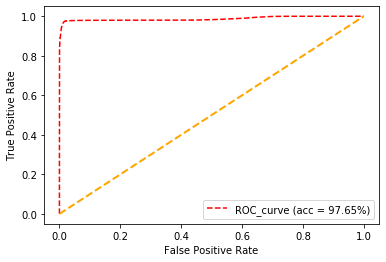

<Figure size 432x288 with 0 Axes>

In [3]:
# 학습된 모델 테스트셋에서 성능 평가
# 얼굴 스푸핑 분야에서 평가 metric으로 HTER이랑 EER 두 개 주로 사용
# =========================================

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight


%matplotlib inline

def main():
    inputSize = 224
    batchSize = 8
    
    testDB = 'CASIA-FASD'
    
    dataDir = 'E:\\Face_Database\\public-Database\\1_crop_result\\CASIA-FASD'
    modelPath = 'C:\\Users\\ysk00\\OneDrive\\바탕 화면\\prlab\\ysg\\densenet-spoofing\\result_CASIA\\Result-14-0.0044.hdf5'
    
    print('>> model loaded: {}'.format(os.path.basename(modelPath)))
    K.clear_session()
    model = load_model(modelPath)
        
    print(">>>> evaluating on '{}'".format(testDB))
    test_datagen = ImageDataGenerator()
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'test']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)

#     ''' evaluating EER '''
#     y_true = val_generator.classes
#     y_score = model.predict_generator(val_generator, steps=len(val_generator)).ravel()

#     fpr, tpr, threshold = roc_curve(y_true, y_score)
#     fnr = 1 - tpr
#     eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
#     val_eer = (fpr[np.nanargmin(np.absolute((fnr - fpr)))] + fnr[np.nanargmin(np.absolute((fnr - fpr)))]) / 2

    ''' evaluating HTER '''
    y_true = test_generator.classes
    y_score = model.predict_generator(test_generator, steps = len(test_generator)).ravel()

    # Calculate EER threshold
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
    
    test_eer = (fpr[np.nanargmin(np.absolute((fnr - fpr)))] + fnr[np.nanargmin(np.absolute((fnr - fpr)))]) / 2

    # HTER
    y_pred = y_score > eer_threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = test_generator.class_indices
    print('                  pred_fake({})   pred_real({})\nactural_fake({})    {:12d}   {:12d}\nactual_real({})    {:12d}   {:12d}\n'.format(labels['Fake'], labels['Real'], labels['Fake'], tn, fp, labels['Real'], fn, tp))
    hter = (fp/(tn+fp) + fn/(fn+tp)) * 0.5

    # ROC curve
    Accuracy = ((tn+tp) / (tn+fp+fn+tp)) * 100.0

    roc_auc = roc_auc_score(y_true, y_score)

    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, 'r--', label='ROC_curve (acc = %0.2f%%)' % Accuracy)
    plt.plot([0, 1], [0, 1], color = 'orange', lw=lw, linestyle='--')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")

    plt.savefig('protocol_4_publicDB.png')
    plt.figure()
    
    print('EER: {:.4f}\tHTER: {:.4f}'.format(test_eer, hter))

    print('>> finished')

        
if __name__ == '__main__':
    main()

# Densenet 오류찾기 (정면이용)

In [8]:
from tensorflow import keras
#keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
from tensorflow.keras.applications.densenet import DenseNet121
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

def Densenet121(show_layers,weights,input_shape):
        base_model = DenseNet121(include_top=False, weights=weights, input_shape=input_shape)
        x = GlobalAveragePooling2D()(base_model.output)
        pred = Dense(1, activation='sigmoid')(x)
    
        model = Model(inputs=base_model.input, outputs=pred)
        model.compile(optimizer=SGD(lr=1e-3, decay=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
        if show_layers:
            for i, layer in enumerate(model.layers):
                print(i, layer.name, layer.trainable)
        return model
    
model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

- 학습

>>  M_angle
============================================Densenet121=============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
train shape : (13680,)
Epoch 1/100
1709/1710 [============================>.] - ETA: 0s - loss: 0.3486 - accuracy: 0.8550
Epoch 00001: val_loss improved from inf to 0.44960, saving model to .\result_cuda\M_angle-01-0.4496.hdf5
1710/1710 [==============================] - 1232s 720ms/step - loss: 0.3488 - accuracy: 0.8548 - val_loss: 0.4496 - val_accuracy: 0.7831
Epoch 2/100
1709/1710 [============================>.] - ETA: 0s - loss: 0.2094 - accuracy: 0.9195
Epoch 00002: val_loss did not improve from 0.44960
1710/1710 [==============================] - 1192s 697ms/step - loss: 0.2095 - accuracy: 0.9195 - val_loss: 1.1868 - val_accuracy: 0.6801
Epoch 3/100
1709/1710 [============================>.] - ETA: 0s - loss: 0.1516 - accuracy: 0.9447
Epoch 00003: val_loss did not improve from 0.4496

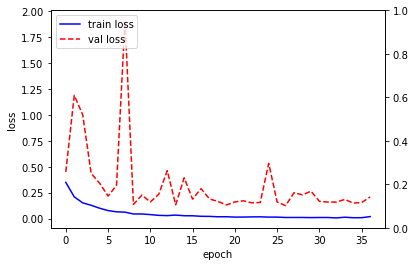

acc: 0.9699	loss: 0.1252
==========================================M_angle finished==========================================


In [9]:
#### import glob
import os
import numpy as np
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 8
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'E:\\Face_Database\\B-Database\\protocol_1'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'M_angle'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'M_angle'
    
    saveDir =  '.\\result_cuda'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('Densenet121'.center(100, '='))
   
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = Densenet121(False,weights=None,input_shape=(224, 224, 3))

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir,trainDB,'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, validDB,'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)

    print('train shape :',train_generator.classes.shape)
    # unbalanced class를 해결하기 위한 class_weight 설정 #np.unique는 중복원소제거하는거
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_accuracy'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

- test

>> model loaded: protocol_4-21-0.0745_0.001.hdf5
>>>> evaluating on 'protocol_4'
Found 30240 images belonging to 2 classes.
Found 56160 images belonging to 2 classes.
                  pred_fake(0)   pred_real(1)
actural_fake(0)           36565            875
actual_real(1)             438          18282

<class 'numpy.ndarray'>
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False

EER: 0.0285	HTER: 0.0234
>> finished


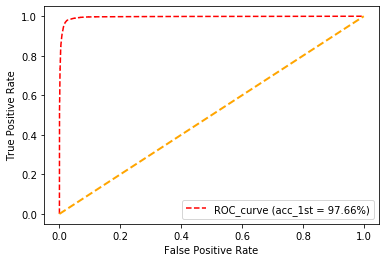

<Figure size 432x288 with 0 Axes>

In [1]:
# 학습된 모델 테스트셋에서 성능 평가
# 얼굴 스푸핑 분야에서 평가 metric으로 HTER이랑 EER 두 개 주로 사용
# =========================================

import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight


%matplotlib inline

def main():
    inputSize = 224
    batchSize = 8
    
    trainDB = 'protocol_4'
    testDB = 'protocol_4'
    
    dataDir = 'E:\\Face_Database\\B-Database'
    modelPath = 'C:\\Users\\ysk00\\OneDrive\\바탕 화면\\prlab\\ysg\\densenet-spoofing\\result_cuda\\protocol_4-21-0.0745_0.001.hdf5'
    
    print('>> model loaded: {}'.format(os.path.basename(modelPath)))
    K.clear_session()
    model = load_model(modelPath)
        
    print(">>>> evaluating on '{}'".format(testDB))
    test_datagen = ImageDataGenerator()

    val_datagen = ImageDataGenerator()
    
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_generator = val_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'val']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)
    
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'test']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)

    ''' evaluating EER '''
    y_true = val_generator.classes
    y_score = model.predict_generator(val_generator, steps=len(val_generator)).ravel()

    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
    val_eer = (fpr[np.nanargmin(np.absolute((fnr - fpr)))] + fnr[np.nanargmin(np.absolute((fnr - fpr)))]) / 2

    ''' evaluating HTER '''
    y_true = test_generator.classes
    y_score = model.predict_generator(test_generator, steps = len(test_generator)).ravel()

    # Calculate EER threshold
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]

    # HTER
    y_pred = y_score > eer_threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = test_generator.class_indices
    print('                  pred_fake({})   pred_real({})\nactural_fake({})    {:12d}   {:12d}\nactual_real({})    {:12d}   {:12d}\n'.format(labels['Fake'], labels['Real'], labels['Fake'], tn, fp, labels['Real'], fn, tp))
    hter = (fp/(tn+fp) + fn/(fn+tp)) * 0.5
    print('=======================')
    np.set_printoptions(threshold=sys.maxsize)
    print(type(y_pred))
    print(y_pred)
    print('=======================')

    # ROC curve
    Accuracy = ((tn+tp) / (tn+fp+fn+tp)) * 100.0

    roc_auc = roc_auc_score(y_true, y_score)

    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, 'r--', label='ROC_curve (acc_1st = %0.2f%%)' % Accuracy)
    plt.plot([0, 1], [0, 1], color = 'orange', lw=lw, linestyle='--')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")

    plt.savefig('protocol_4_001.png')
    plt.figure()
    
    print('EER: {:.4f}\tHTER: {:.4f}'.format(val_eer, hter))

    print('>> finished')

        
if __name__ == '__main__':
    main()

# CROSS VALIDATION

- Train(CASIA0 -> Test(PR) 

In [ ]:
# 학습된 모델 테스트셋에서 성능 평가
# 얼굴 스푸핑 분야에서 평가 metric으로 HTER이랑 EER 두 개 주로 사용
# =========================================

import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight


%matplotlib inline

def main():
    inputSize = 224
    batchSize = 8
    
    trainDB = 'protocol_4'
    testDB = 'CASIA-FASD'
    
    dataDir = 'E:\\Face_Database\\public-Database\\1_crop_result'
    modelPath = 'F:\\prlab\\ysg\\densenet-spoofing\\Densenet_result\\0.001\\result_PR-FASD\\protocol_4-21-0.0745_0.001.hdf5'
    
    print('>> model loaded: {}'.format(os.path.basename(modelPath)))
    K.clear_session()
    model = load_model(modelPath)
        
    print(">>>> evaluating on '{}'".format(testDB))
    test_datagen = ImageDataGenerator()

    val_datagen = ImageDataGenerator()
    
    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_generator = val_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'val']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)
    
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(os.path.join(*[dataDir, testDB, 'test']),
                                                      target_size=(inputSize, inputSize),
                                                      batch_size=batchSize,
                                                      class_mode='binary',
                                                      interpolation='bilinear',
                                                      shuffle=False,)

    ''' evaluating EER '''
    y_true = val_generator.classes
    y_score = model.predict_generator(val_generator, steps=len(val_generator)).ravel()

    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]
    val_eer = (fpr[np.nanargmin(np.absolute((fnr - fpr)))] + fnr[np.nanargmin(np.absolute((fnr - fpr)))]) / 2

    ''' evaluating HTER '''
    y_true = test_generator.classes
    y_score = model.predict_generator(test_generator, steps = len(test_generator)).ravel()

    # Calculate EER threshold
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr-fpr)))]

    # HTER
    y_pred = y_score > eer_threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = test_generator.class_indices
    print('                  pred_fake({})   pred_real({})\nactural_fake({})    {:12d}   {:12d}\nactual_real({})    {:12d}   {:12d}\n'.format(labels['Fake'], labels['Real'], labels['Fake'], tn, fp, labels['Real'], fn, tp))
    hter = (fp/(tn+fp) + fn/(fn+tp)) * 0.5
    print('=======================')
    np.set_printoptions(threshold=sys.maxsize)
    print(type(y_pred))
    print(y_pred)
    print('=======================')

    # ROC curve
    Accuracy = ((tn+tp) / (tn+fp+fn+tp)) * 100.0

    roc_auc = roc_auc_score(y_true, y_score)

    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, 'r--', label='ROC_curve (acc_1st = %0.2f%%)' % Accuracy)
    plt.plot([0, 1], [0, 1], color = 'orange', lw=lw, linestyle='--')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "lower right")

    plt.savefig('protocol_4_001.png')
    plt.figure()
    
    print('EER: {:.4f}\tHTER: {:.4f}'.format(val_eer, hter))

    print('>> finished')

        
if __name__ == '__main__':
    main()

>> model loaded: protocol_4-21-0.0745_0.001.hdf5
